In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets 
from torchvision import transforms

import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

In [2]:
batch_size        = 128
device            = torch.device('cuda')
means             = torch.tensor((0.4914, 0.4822, 0.4465)).to(device)
stds              = torch.tensor((0.2023, 0.1994, 0.2010)).to(device)
normalize         = lambda x: (x - means) / stds
normalize_red     = lambda x: (x - means[0]) / stds[0]
normalize_green   = lambda x: (x - means[1]) / stds[1]
normalize_blue    = lambda x: (x - means[2]) / stds[2]
reverse_normalize = lambda x: (x * stds) + means

In [3]:
def display_img(img):
    img_data = lambda img: reverse_normalize(img.squeeze().permute(1,2,0)).data.cpu().numpy().clip(0, 1)
    plt.imshow(img_data(img))    

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        '../data',
        train = True,
        download = True,
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(means, stds)
            ]
        )
    ),
    shuffle = True,
    batch_size = batch_size
)

Files already downloaded and verified


In [5]:
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        '../data',
        train = False,
        download = True,
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(means, stds)
            ]
        )
    ),
    shuffle = False,
    batch_size = 2 * batch_size
)

Files already downloaded and verified


In [6]:
def train(model, device, train_loader, optimizer, criterion, n_epochs, log_interval):
    model.train()
    for epoch in tqdm_notebook(range(n_epochs), desc = 'Epochs'):
        for batch_idx, (X, y) in tqdm_notebook(enumerate(train_loader), total = len(train_loader), desc = 'Batches', leave = False):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print(f'Train epoch {epoch}: [{batch_idx * len(X):5d}/{len(train_loader.dataset):5d}] Loss: {loss.item():7.4f}')

In [7]:
def evaluate(model, device, test_loader, criterion):
    model.eval()
    test_set_size = len(test_loader.dataset)
    correct_answers = 0
    sum_loss = 0
    with torch.no_grad():
        for X, y in tqdm_notebook(test_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            class_pred = y_pred.argmax(dim = 1)
            correct_answers += (y == class_pred).sum().item()
            sum_loss += criterion(y_pred, y).item()
    accuracy = correct_answers / test_set_size
    average_loss = sum_loss / len(test_loader)
    
    return accuracy, average_loss

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3 , 32 , 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 32 , 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64,  3, padding = 1)
        self.conv4 = nn.Conv2d(64, 64,  3, padding = 1)
        self.fc1   = nn.Linear(64 * 8 * 8, 128)
        self.fc2   = nn.Linear(128      , 10)
        
    def forward(self, x):
        x = F.dropout(F.relu(self.conv1(x)), 0.2)
        x = F.dropout(F.relu(self.conv2(x)), 0.2)
        x = F.max_pool2d(x, kernel_size = (2, 2))
        x = F.dropout(F.relu(self.conv3(x)), 0.2)
        x = F.dropout(F.relu(self.conv4(x)), 0.2)
        x = F.max_pool2d(x, kernel_size = (2, 2))
        x = x.view(-1, 64 * 8 * 8)
        x = F.dropout(F.relu(self.fc1(x)), 0.2)
        x = self.fc2(x)
        
        return x

In [9]:
cnn       = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters())

In [10]:
train(cnn, device, train_loader, optimizer, criterion, 10, len(train_loader) // 5)

Train epoch 0: [    0/50000] Loss:  2.3082
Train epoch 0: [ 9984/50000] Loss:  1.7547
Train epoch 0: [19968/50000] Loss:  1.5453
Train epoch 0: [29952/50000] Loss:  1.4715
Train epoch 0: [39936/50000] Loss:  1.3071
Train epoch 0: [31200/50000] Loss:  1.2574


Train epoch 1: [    0/50000] Loss:  1.3461
Train epoch 1: [ 9984/50000] Loss:  1.1517
Train epoch 1: [19968/50000] Loss:  1.1618
Train epoch 1: [29952/50000] Loss:  1.1146
Train epoch 1: [39936/50000] Loss:  1.0621
Train epoch 1: [31200/50000] Loss:  0.9232


Train epoch 2: [    0/50000] Loss:  0.8369
Train epoch 2: [ 9984/50000] Loss:  0.8589
Train epoch 2: [19968/50000] Loss:  0.7216
Train epoch 2: [29952/50000] Loss:  0.8969
Train epoch 2: [39936/50000] Loss:  0.9769
Train epoch 2: [31200/50000] Loss:  0.6969


Train epoch 3: [    0/50000] Loss:  0.7569
Train epoch 3: [ 9984/50000] Loss:  0.8726
Train epoch 3: [19968/50000] Loss:  0.8037
Train epoch 3: [29952/50000] Loss:  0.8867
Train epoch 3: [39936/50000] Loss:  0.9038
Train epoch 3: [31200/50000] Loss:  0.9446


Train epoch 4: [    0/50000] Loss:  0.6903
Train epoch 4: [ 9984/50000] Loss:  0.7263
Train epoch 4: [19968/50000] Loss:  0.6917
Train epoch 4: [29952/50000] Loss:  0.5601
Train epoch 4: [39936/50000] Loss:  0.8273
Train epoch 4: [31200/50000] Loss:  0.7365


Train epoch 5: [    0/50000] Loss:  0.8033
Train epoch 5: [ 9984/50000] Loss:  0.6177
Train epoch 5: [19968/50000] Loss:  0.6674
Train epoch 5: [29952/50000] Loss:  0.7717
Train epoch 5: [39936/50000] Loss:  0.6121
Train epoch 5: [31200/50000] Loss:  0.8568


Train epoch 6: [    0/50000] Loss:  0.5476
Train epoch 6: [ 9984/50000] Loss:  0.6856
Train epoch 6: [19968/50000] Loss:  0.5216
Train epoch 6: [29952/50000] Loss:  0.5536
Train epoch 6: [39936/50000] Loss:  0.5996
Train epoch 6: [31200/50000] Loss:  0.6659


Train epoch 7: [    0/50000] Loss:  0.6056
Train epoch 7: [ 9984/50000] Loss:  0.5551
Train epoch 7: [19968/50000] Loss:  0.5355
Train epoch 7: [29952/50000] Loss:  0.5014
Train epoch 7: [39936/50000] Loss:  0.5050
Train epoch 7: [31200/50000] Loss:  0.6030


Train epoch 8: [    0/50000] Loss:  0.5391
Train epoch 8: [ 9984/50000] Loss:  0.4663
Train epoch 8: [19968/50000] Loss:  0.4702
Train epoch 8: [29952/50000] Loss:  0.7216
Train epoch 8: [39936/50000] Loss:  0.4221
Train epoch 8: [31200/50000] Loss:  0.6122


Train epoch 9: [    0/50000] Loss:  0.5090
Train epoch 9: [ 9984/50000] Loss:  0.5558
Train epoch 9: [19968/50000] Loss:  0.4082
Train epoch 9: [29952/50000] Loss:  0.4719
Train epoch 9: [39936/50000] Loss:  0.4724
Train epoch 9: [31200/50000] Loss:  0.5121



In [11]:
accuracy, avg_loss = evaluate(cnn, device, train_loader, criterion)
print(f'[Train] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')
accuracy, avg_loss = evaluate(cnn, device, test_loader, criterion)
print(f'[Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')


[Train] Accuracy: 83.33%, loss:  0.4714



[Test] Accuracy: 72.59%, loss:  0.8455


Real label: 1
Predicted label: 1


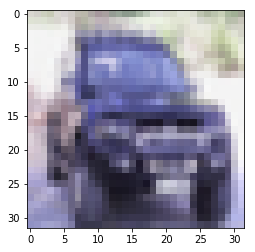

In [12]:
X, y  = next(iter(test_loader))
X     = X.to(device)
ex_id = 9
img   = X[ex_id].permute(1,2,0)
img   = reverse_normalize(img)
plt.imshow(img.cpu())
print(f'Real label: {y[ex_id].item()}')
print(f'Predicted label: {cnn(X.to(device))[ex_id].argmax().item()}')

In [13]:
def generate_adv_example(model, epsilon, criterion, X):
    X.requires_grad = True
    y_pred          = model(X)
    loss            = criterion(y_pred, y_pred.argmax(dim = 1))
    loss.backward()
    adv_example     = X + epsilon * X.grad.sign()
    
    # Clamping the result to [0, 1] in each channel.
    # I don't think that there exist a multidimensional clamp function.
    for channel, norm_func in enumerate([normalize_red, normalize_green, normalize_blue]):
        adv_example[:, channel, ...].clamp_(norm_func(0), norm_func(1))
    
    return adv_example

In [14]:
def adv_sample_process(model, epsilon, ex_idx, X, y):
    source = X[ex_idx, ...].unsqueeze(0).to(device)
    y_pred = model(source)
    adv_example = generate_adv_example(model, epsilon, criterion, source)
    adv_pred = cnn(adv_example)
    for i in range(10):
        print(f'Class {i}: {y_pred[0, i]:6.4f} \t->\t {adv_pred[0, i]:^6.4f}')
    plt.figure(figsize = (15, 10))
    plt.subplot(1, 2, 1)
    display_img(source)
    plt.subplot(1, 2, 2)
    display_img(adv_example)
    print(f'Real label: {y[ex_idx].item()}')
    print(f'Predicted label: {adv_pred[0].argmax().item()}')

Class 0: -6.9787 	->	 -5.5062
Class 1: -4.6078 	->	 -7.3761
Class 2: -0.0882 	->	 0.7422
Class 3: 0.5642 	->	 5.4062
Class 4: 1.0190 	->	 0.4319
Class 5: 0.8037 	->	 5.0380
Class 6: 6.2724 	->	 0.3613
Class 7: -0.2041 	->	 4.1181
Class 8: -8.3461 	->	 -11.1287
Class 9: -4.1470 	->	 -4.1740
Real label: 6
Predicted label: 3


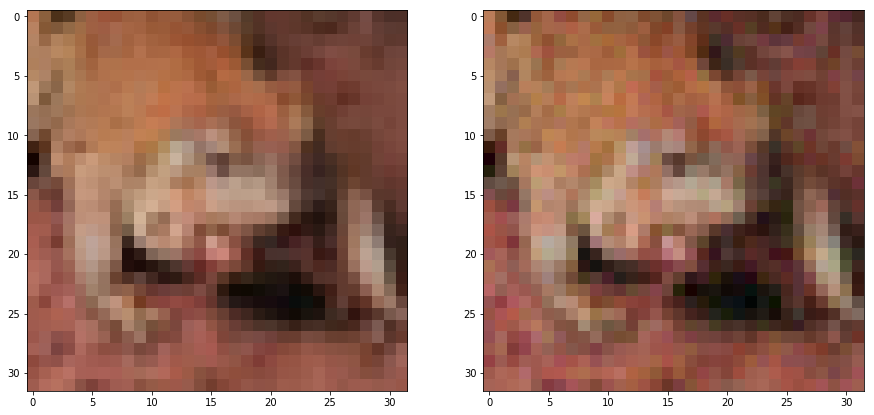

In [16]:
adv_sample_process(cnn, 0.15, 5, X, y)